<a href="https://colab.research.google.com/github/SartajHundal/DroneSimulations/blob/main/DroneLocalization_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routine Library Calls and Extractions

1.   NEW (22.02.24): When you are doing a mv in Google Colab, the notebook does not synchronize on the left-hand 'Files' pane until the browser tab has been refreshed
2.   PEP8 has been employed, with a larger focus on Data Engineering cleansing tasks / requirements focus from the [Gist](https://gist.github.com/theikkila/dbc7d15b320577bcfee6b1135415a3bc)
3. OpenAI & prompt engineering are not a silver bullet, but this is what I can do in 7.5 hours without fully precise documentation. The rest of the testing was abandoned notebooks around A-star, Breadth-First Search, and chaotic behaviour with 'too many' system variables that didn't quite shore up with the **required** solution output as it should


In [ ]:
from google.colab import drive
from PIL import Image
from scipy.ndimage import gaussian_filter
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [ ]:
def load_occupancy_map(map_path):
    """
    Load the occupancy map from a PNG file.

    Parameters:
    - map_path (str): Path to the PNG file containing the occupancy map.

    Returns:
    - occupancy_map (numpy.ndarray): Occupancy map of the environment.
    """
    # Load the PNG image
    map_image = Image.open(map_path)

    # Convert the image to grayscale
    map_gray = map_image.convert('L')

    # Convert the image to a numpy array
    occupancy_map = np.array(map_gray)

    return occupancy_map

In [ ]:
def load_sensor_log(log_path):
    with open(log_path, 'r') as f:
        return [json.loads(line) for line in f]

# Transformation

In [ ]:
def denoise_lidar_measurements(lidar_measurements, variance=4.4):
    """
    Denoise lidar measurements using Gaussian smoothing. Suppose that mean = 0
    and variance = 4.4 are at a constant rate from the measurement actuals

    Parameters:
    - lidar_measurements (list): List of lidar measurements.
    - variance (float): Variance of the Gaussian filter.

    Returns:
    - denoised_measurements (list): List of denoised lidar measurements.
    """
    # Convert lidar measurements to numpy array
    lidar_array = np.array(lidar_measurements)

    # Apply Gaussian smoothing
    denoised_array = gaussian_filter(lidar_array, sigma=np.sqrt(variance))

    # Convert back to list
    denoised_measurements = denoised_array.tolist()

    return denoised_measurements

In [56]:
def visualize_path_on_map(occupancy_map_path, dataset):
    # Load occupancy map
    occupancy_map = cv2.imread(occupancy_map_path, cv2.IMREAD_GRAYSCALE)

    # Convert map to color for visualization
    occupancy_map_color = cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2BGR)

    # Initialize drone path with the initial odometry position
    drone_path = [(int(round(dataset['odometry_x'].iloc[0])), int(round(dataset['odometry_y'].iloc[0])))]

    # Iterate through each row in the dataset
    for i in range(len(dataset)):
        # Get lidar measurements for the current row
        lidar_measurements = dataset['lidar'].iloc[i]

        # Calculate positions based on lidar measurements
        for angle, distance in enumerate(lidar_measurements):
            if distance != -1:
                # Convert angle to radians
                angle_rad = math.radians(angle * 10)
                # Calculate position based on odometry readings and lidar measurements
                next_x = drone_path[-1][0] + distance * math.cos(angle_rad)
                next_y = drone_path[-1][1] + distance * math.sin(angle_rad)
                # Add calculated position to the drone's path
                drone_path.append((int(round(next_x)), int(round(next_y))))

    # Save drone path to CSV
    df_path = pd.DataFrame(drone_path, columns=['x', 'y'])
    df_path.to_csv('drone_path.csv', index=False)

    # Plot drone path on the map
    for i in range(1, len(drone_path)):
        cv2.line(occupancy_map_color, drone_path[i - 1], drone_path[i], (0, 255, 0), 2)

    # Show the map with the drone's path
    plt.imshow(occupancy_map_color)
    plt.title('Drone Path on Occupancy Map')
    plt.axis('off')
    plt.show()


In [ ]:
def denoised_vis(occupancy_map_path, dataset):
    # Load occupancy map
    occupancy_map = cv2.imread(occupancy_map_path, cv2.IMREAD_GRAYSCALE)

    # Convert map to color for visualization
    occupancy_map_color = cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2BGR)

    # Initialize drone path with the initial odometry position
    drone_path = [(int(round(dataset['odometry_x'].iloc[0])), int(round(dataset['odometry_y'].iloc[0])))]

    # Iterate through each row in the dataset
    for i in range(len(dataset)):
        # Get lidar measurements for the current row
        lidar_measurements = dataset['lidar'].iloc[i]

        # Denoise lidar measurements
        denoised_measurements = denoise_lidar_measurements(lidar_measurements)

        # Calculate positions based on denoised lidar measurements
        for angle, distance in enumerate(denoised_measurements):
            if distance != -1:
                # Convert angle to radians
                angle_rad = math.radians(angle * 10)
                # Calculate position based on odometry readings and lidar measurements
                next_x = drone_path[-1][0] + distance * math.cos(angle_rad)
                next_y = drone_path[-1][1] + distance * math.sin(angle_rad)
                # Add calculated position to the drone's path
                drone_path.append((int(round(next_x)), int(round(next_y))))

    # Plot drone path on the map
    for i in range(1, len(drone_path)):
        cv2.line(occupancy_map_color, drone_path[i - 1], drone_path[i], (0, 255, 0), 2)

    # Show the map with the drone's path
    plt.imshow(occupancy_map_color)
    plt.title('Drone Path on Occupancy Map')
    plt.axis('off')
    plt.show()

In [44]:
def cleansing_experiment(occupancy_map_path, dataset):
    # Load occupancy map
    occupancy_map = cv2.imread(occupancy_map_path, cv2.IMREAD_GRAYSCALE)

    # Convert map to color for visualization
    occupancy_map_color = cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2BGR)

    # Initialize drone path with the initial odometry position
    drone_path = [(int(round(dataset['odometry_x'].iloc[0])), int(round(dataset['odometry_y'].iloc[0])))]

    # Iterate through each row in the dataset
    for i in range(len(dataset)):
        # Get lidar measurements for the current row
        lidar_measurements = dataset['lidar'].iloc[i]

        # Filter out -1 values from lidar measurements
        lidar_measurements = list(filter(lambda x: x != -1, lidar_measurements))

        # Calculate positions based on denoised lidar measurements
        for angle, distance in enumerate(lidar_measurements):
            # Convert angle to radians
            angle_rad = math.radians(angle * 10)
            # Calculate position based on odometry readings and lidar measurements
            next_x = drone_path[-1][0] + distance * math.cos(angle_rad)
            next_y = drone_path[-1][1] + distance * math.sin(angle_rad)

            # Adjust position to stay within map bounds
            while occupancy_map.shape[0] > next_y >= 0 and occupancy_map.shape[1] > next_x >= 0 and occupancy_map[int(next_y), int(next_x)] != 0:
                scale = 0.1  # Adjust as needed
                next_x -= scale * math.cos(angle_rad)
                next_y -= scale * math.sin(angle_rad)

            # Add calculated position to the drone's path
            drone_path.append((int(round(next_x)), int(round(next_y))))

    # Plot drone path on the map
    for i in range(1, len(drone_path)):
        cv2.line(occupancy_map_color, drone_path[i - 1], drone_path[i], (0, 255, 0), 2)

    # Show the map with the drone's path
    plt.imshow(occupancy_map_color)
    plt.title('Drone Path on Occupancy Map (Denoised)')
    plt.axis('off')
    plt.show()


In [45]:
def cleansing_experiment_1(occupancy_map_path, dataset):
    # Load occupancy map
    occupancy_map = cv2.imread(occupancy_map_path, cv2.IMREAD_GRAYSCALE)

    # Convert map to color for visualization
    occupancy_map_color = cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2BGR)

    # Initialize drone path with the initial odometry position
    drone_path = [(int(round(dataset['odometry_x'].iloc[0])), int(round(dataset['odometry_y'].iloc[0])))]

    # Iterate through each row in the dataset
    for i in range(len(dataset)):
        # Get odometry readings for the current row
        x0, y0 = dataset['odometry_x'].iloc[i], dataset['odometry_y'].iloc[i]

        # Use Lidar measurements to calculate positions based on actual data
        for angle, distance in enumerate(dataset['lidar'].iloc[i]):
            if distance != -1:
                # Convert angle to radians
                angle_rad = math.radians(angle * 10)
                # Calculate position based on actual Lidar measurements
                next_x = x0 + distance * math.cos(angle_rad)
                next_y = y0 + distance * math.sin(angle_rad)
                # Add calculated position to the drone's path if the next position is within the map boundaries
                if 0 <= int(next_y) < occupancy_map.shape[0] and 0 <= int(next_x) < occupancy_map.shape[1] \
                        and occupancy_map[int(next_y), int(next_x)] == 0:
                    drone_path.append((int(round(next_x)), int(round(next_y))))
                else:
                    break  # Stop if the next position is outside the map or hits an obstacle

    # Plot drone path on the map
    for i in range(1, len(drone_path)):
        cv2.line(occupancy_map_color, drone_path[i - 1], drone_path[i], (0, 255, 0), 2)

    # Show the map with the drone's path
    plt.imshow(occupancy_map_color)
    plt.title('Drone Path on Occupancy Map with Naive Distance Measurement')
    plt.axis('off')
    plt.show()

# Loaders and Visualization

In [48]:
# Load occupancy map and sensor log data (update paths as needed)
# Yes, this can be abstracted out as a file uploader
occupancy_map_path = "/content/drive/MyDrive/Drone (shared)/map_stadi_bg.png"
sensor_log_path = "/content/drive/MyDrive/Drone (shared)/drone_log.jsonl"

occupancy_map = load_occupancy_map(occupancy_map_path)
sensor_log = load_sensor_log(sensor_log_path)

In [49]:
# Read JSONL file into a DataFrame
df = pd.read_json(sensor_log_path, lines=True)
df_0 = pd.read_json(sensor_log_path, lines=True)

# Assuming df is your DataFrame containing the dataset, remove the -1 values
# It is guaranteed that the map boundary crossings are removed now
df_0['lidar'] = df_0['lidar'].apply(lambda x: [value for value in x if value != -1])

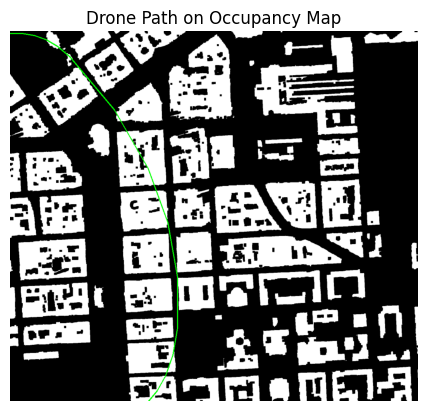

In [57]:
visualize_path_on_map(occupancy_map_path, df_0)

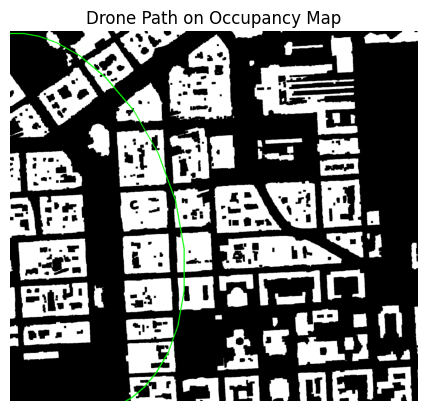

In [51]:
denoised_vis(occupancy_map_path, df_0)

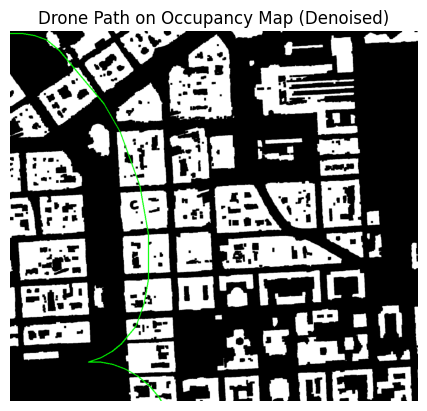

In [54]:
cleansing_experiment(occupancy_map_path, df)

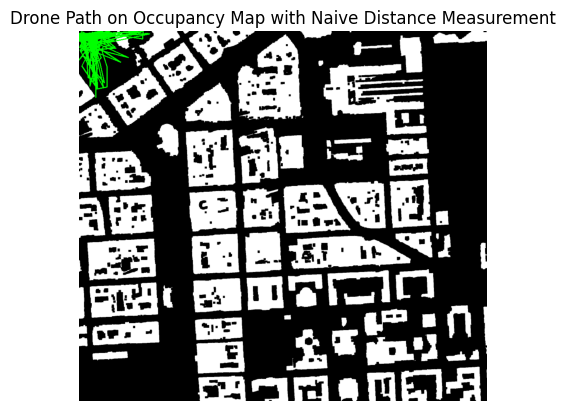

In [55]:
cleansing_experiment_1(occupancy_map_path, df_0)

# Results from Best Hit
You will get a file called drone_path.csv in your top-level directory. The first hit should be (0, 6) and it goes up to (-22492, 26261). This should be more fine-tuning work or further transformations during downstream experiments.